## **What is pmdarima library used for?**
Pmdarima is a Python library used for time series forecasting and analysis. It provides automated ARIMA (AutoRegressive Integrated Moving Average) modeling capabilities, similar to R's auto.arima function. Key features include:
> Automatic selection of optimal ARIMA parameters
> Seasonal and non-seasonal ARIMA modeling

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
display(df)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## **Plot Data using matplotlib**

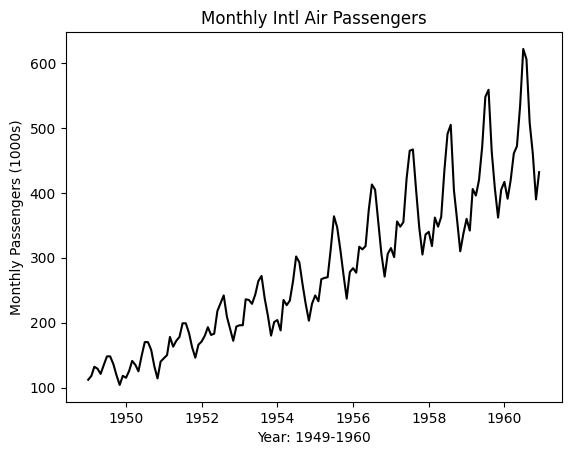

In [4]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### **Splitting the Dataset for Training and Testing:**

- Our goal is to predict future values in the time series.
- To do this, we'll use data from 1949 through 1957 for training the model.
- We'll then use data from 1958 through 1960 for testing the predictions.

In [5]:
trn = df.loc[df.index < '1958-01-01']

In [6]:
display(trn)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1957-08-01,467
1957-09-01,404
1957-10-01,347


**Plot the Training Data:**

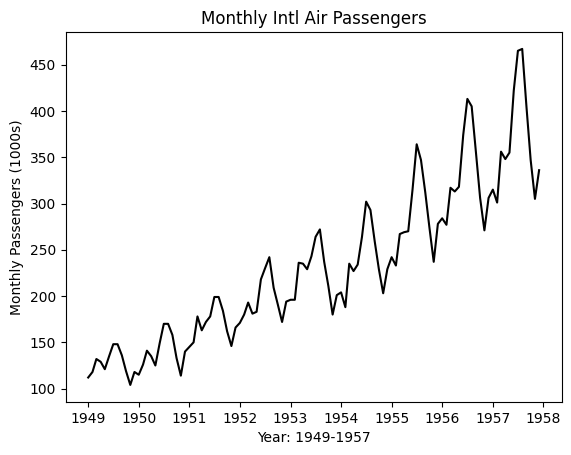

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### *Creating Testing data:*

In [8]:
tst = df.loc[df.index >= '1958-01-01']

- Plot the testing data.
- Note that the vertical scale changes from the previous graph.

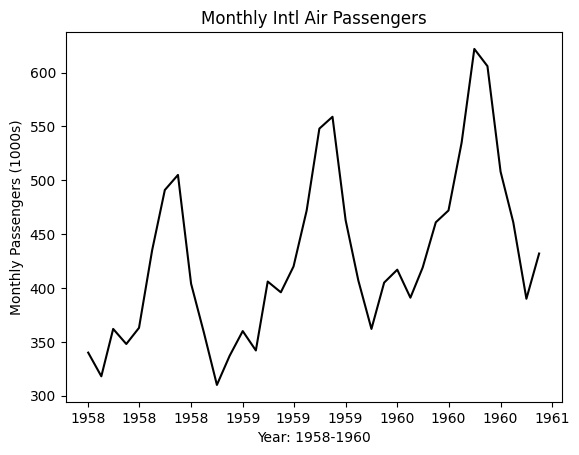

In [9]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## **Build the ML model:**

### *Test Stationarity:*

ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

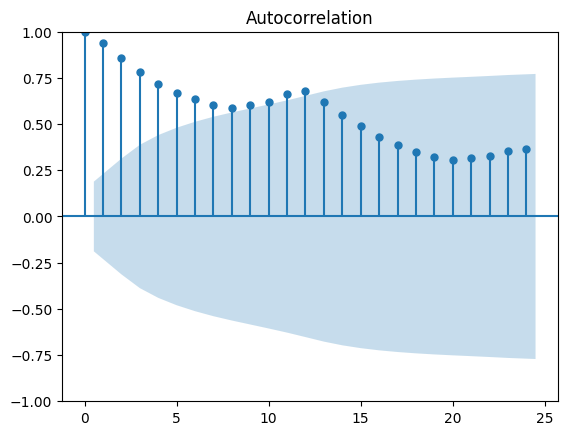

In [10]:
trn_acf = plot_acf(trn, lags=24)

### **Linear Model:**

- Fit a linear regression model to serve as a baseline. 
- The dependent (or endogenous) variable is the number of passengers. 
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [11]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           6.40e-43
Time:                        00:24:54   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [12]:
y_hat = lr.fittedvalues

In [13]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

**Graph time series with linear regression line and corresponding 95% prediction interval:**

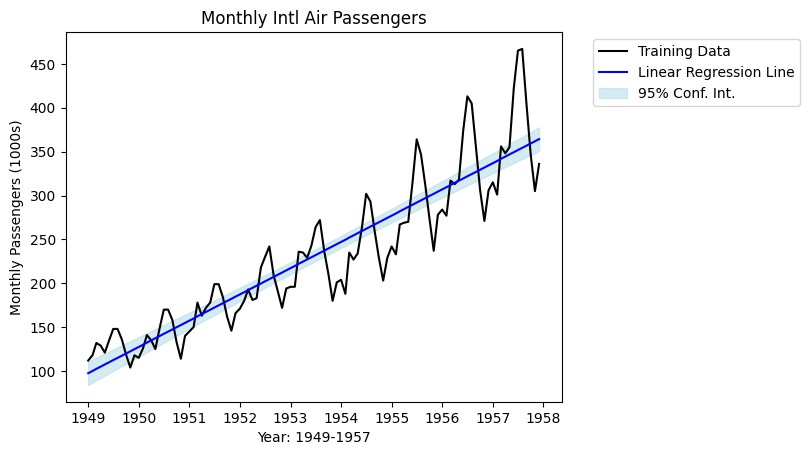

In [14]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## **ARIMA: Begin training the model.**

In [15]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Fri, 17 Jan 2025   AIC                            704.001
Time:                                    00:32:07   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

- The `auto_arima` function suggests `ARIMA(1,1,0)(0,1,0,12)`.    

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [16]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [17]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [19]:
resid = auto_arima_model.resid()

**Plot the standardized residuals.**

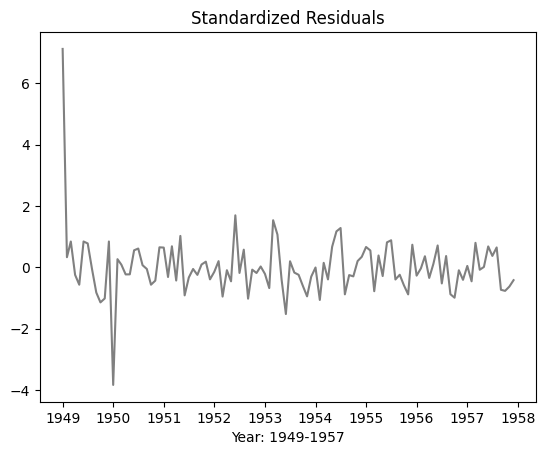

In [20]:
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

**Plot the ACF (autocorrelation function) of the residuals.**

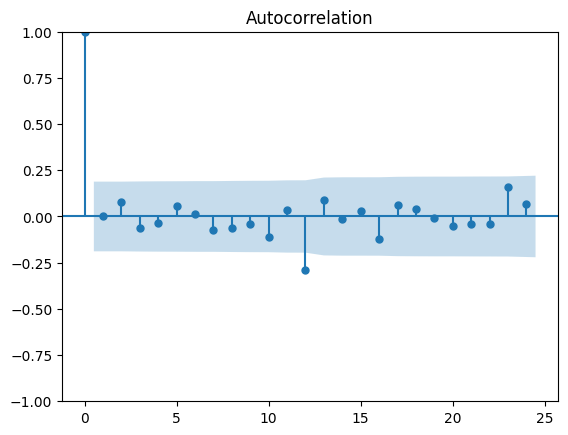

In [21]:
res_acf = plot_acf(resid, lags=24)

**Plot the p-values of the Ljung-Box test for autocorrelation.**

In [24]:
result = acorr_ljungbox(resid, lags=24, return_df=False)
print(result)

      lb_stat  lb_pvalue
1    0.000442   0.983222
2    0.648912   0.722920
3    1.068286   0.784735
4    1.223401   0.874231
5    1.600094   0.901238
6    1.629495   0.950434
7    2.276022   0.942999
8    2.769936   0.947955
9    2.955801   0.966022
10   4.450808   0.924728
11   4.602571   0.948878
12  15.120342   0.234921
13  16.122300   0.242589
14  16.141834   0.304790
15  16.240301   0.366263
16  18.185523   0.313146
17  18.729005   0.344307
18  18.958041   0.394412
19  18.968896   0.458833
20  19.333282   0.500267
21  19.546735   0.550111
22  19.782638   0.596634
23  23.222570   0.447838
24  23.858490   0.469713


In [26]:
res_lb = result["lb_pvalue"] 

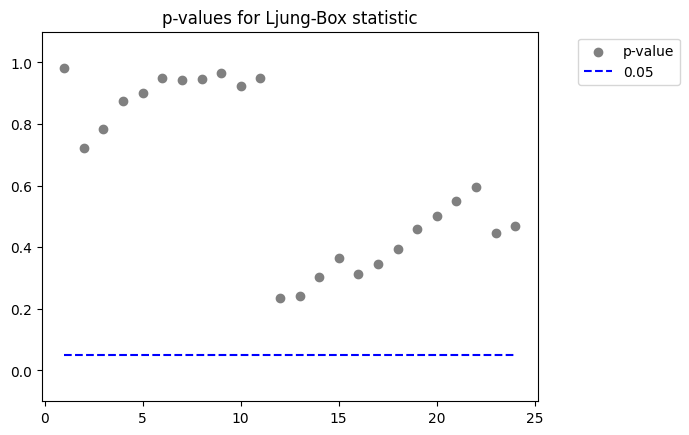

In [27]:
fig, ax = plt.subplots()
plt.title('p-values for Ljung-Box statistic')
plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1))

## **ARIMA: Testing the model.**

In [28]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [29]:
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

In [30]:
y_pred = pd.Series(arima_predictions[0], index=tst.index)

In [31]:
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

- Graph the training data (1949-1957).
- Add the predictions for the testing data (1958-1960).
- Add observed values from testing data.

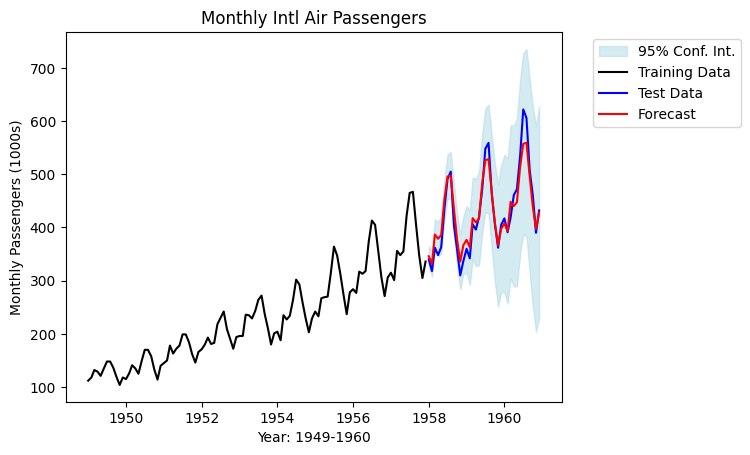

In [32]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data')
plt.plot(tst, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- Create a dataframe with the observed values for the testing dataset.
- Add the predictions from the ARIMA model.
- Add the low and high boundaries for the 95% confidence intervals.

In [33]:
tst_pred = pd.DataFrame({
    'Actual': tst.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

In [34]:
display(tst_pred)

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515740,415.060244
1958-04-01,348,378.774472,346.695454,410.853490
1958-05-01,363,385.777732,350.270764,421.284700
1958-06-01,435,452.776946,414.151074,491.402819
1958-07-01,491,495.777136,454.264678,537.289593
1958-08-01,505,497.777090,453.566424,541.987756
1958-09-01,404,434.777101,388.023615,481.530587
